In [32]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math

In [33]:
class Model:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(Dense(512, input_dim = self.input_dim, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(lr = self.lr, rho = 0.95, epsilon = 0.01), loss = "mse", metrics = ['accuracy'])
        return model

In [34]:
history = [] 
reward_data = []
epsilon_data = []

In [35]:

ENV_NAME = "CartPole-v1"

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 1000000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.999

In [36]:
class DQNSolver:
    def __init__(self,  decay_coe = 0.99975, 
                  memory_size = 10_000,  C = 5):
        
        #self.env = gym.make('CartPole-v0')

        self.states = 4
        self.n_actions = 2
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = Model(self.states, self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self, time):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        self.epsilon*=0.995

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            action = np.argmax(self.model.Qpolicy.predict(states))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    
    def graphs(self, episode):
        f1 = plt.figure(1)
        plt.plot([i for i in range(len(self.reward_data))], self.reward_data)
        plt.ylabel('Score per episode')
        plt.xlabel('Episodes')
        #plt.savefig(r'RL/reward - e{}v2.png'.format(episode), dpi = 500)
        
        f2 = plt.figure(2)
        plt.plot([i for i in range(len(self.epsilon_data))], self.epsilon_data)
        plt.ylabel('Epsilon')
        plt.xlabel('Episodes')
        #plt.savefig(r'RL/epsilon - e{}v2.png'.format(episode), dpi = 500)
        
        f3 = plt.figure(3)
        plt.plot([i for i in range(len(self.history))], self.history)
        plt.ylabel('Loss')
        plt.xlabel('Iterations')
        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            qvalue = self.model.Qpolicy.predict(s)[0]
            print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            future_qvalue = self.model.Qtarget.predict(s_)[0]

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index])
            
                
                qcurr = qvalue[index][0]
                qcurr[action] = Qtarget                
                X.append(state)
                y.append(qcurr)
                
            X, y = np.array(X).reshape(1,self.batch_size,1,self.states), np.array(y).reshape(1,self.batch_size, 1, self.n_actions)
                                        
            loss = self.model.Qpolicy.fit(X, y, batch_size = self.batch_size, shuffle = False, verbose = 0)
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [37]:
dqn_solver=DQNSolver()

In [38]:
no_trains_array=[]

In [39]:
def training(dqn_solver,episodes):
    timestep_reward = 0
    env = gym.make(ENV_NAME)
    no_trains=0
    
    for episode in tqdm(range(1, episodes+1), ascii = True, unit = 'episode'): 
        s = env.reset()
        done = False
        score = 0
        target_counter=0
        while done != True:
            a = dqn_solver.act(s)
            
            s_, r, done,_,_= env.step(a)
            
            # Update 
            
            if(done==True):
                target_counter+=1

            dqn_solver.remember(s,a,r,s_,done)
            no_trains+=1
            dqn_solver.train()
            if((target_counter%5==0)and(len(dqn_solver.memory)>64)):
                dqn_solver.update_target_model()
            
            s = s_
            score += r
            
        dqn_solver.decrement_epsilon(episode)  

        # UPDATE
        reward_data.append(score)
        epsilon_data.append(dqn_solver.epsilon)
        no_trains_array.append(no_trains)
        #if episode % self.timestep == 0: 

In [40]:
training(dqn_solver,150)

  0%|          | 0/150 [00:00<?, ?episode/s]C:\Users\prati\AppData\Local\Temp/ipykernel_85780/1829768437.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states)
  1%|          | 1/150 [00:06<16:44,  6.74s/episode]


ValueError: could not broadcast input array from shape (4,) into shape (1,)

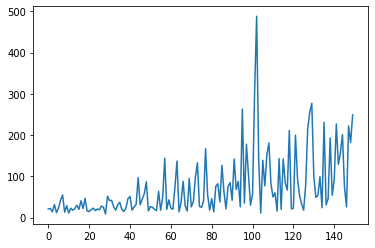

In [ ]:
plt.plot(reward_data)

In [ ]:
no_trains_array[50]

1528